**Imports**

In [ ]:
import requests
import urllib
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Input, Dense, Reshape,Embedding,dot

from sklearn.model_selection import train_test_split

In [ ]:
token = "token"
!git clone https://{token}@github.com/Raghav-Sahni/Hope_speech.git

Cloning into 'Hope_speech'...
remote: Enumerating objects: 700, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 700 (delta 151), reused 228 (delta 125), pack-reused 439
Receiving objects: 100% (700/700), 68.67 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (411/411), done.


**Verify Setup**

In [ ]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.9.2
keras version 2.9.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv("/content/Hope_speech/Data/PreprocessedData/english_train_preprocess.csv")
df_test = pd.read_csv("/content/Hope_speech/Data/PreprocessedData/english_test_preprocess.csv")
df_dev = pd.read_csv("/content/Hope_speech/Data/PreprocessedData/english_dev_preprocess.csv")

In [ ]:
aug_df = pd.read_csv("/content/Hope_speech/Data/AugmentedData/english_train_augmented.csv")

In [ ]:
aug_df.head()

,Unnamed: 0,augmented_text,label
0,0,engineer network here 23 presently working as ...,Hope_speech
1,1,engineer network here 23 and presently instruc...,Hope_speech
2,2,Still im hiding grammatical gender to my paren...,Hope_speech
3,3,im hide still my gender to my parents and they...,Hope_speech
4,4,all subject without lives that we never have p...,Hope_speech


In [ ]:
df_test.head()

,Unnamed: 0,text,label,preprocessed_text
0,0,What do you mean by the word sniped?,Non_hope_speech,what do you mean by the word sniped
1,1,I love this video!! I’m bisexual and it’s just...,Hope_speech,i love this video i ’ m bisexual and it ’ s ju...
2,2,ya the irony but then i don't want to come off...,Non_hope_speech,ya the irony but then i dont want to come off ...
3,3,A PERSON'S CHARACTER MATTERS. PERIOD!!,Non_hope_speech,a persons character matters period
4,4,@Blaster of Gasters,Non_hope_speech,<user> of gasters


In [ ]:
df_dev.head()

,Unnamed: 0,text,label,preprocessed_text
0,0,Thats it.... like....I dont like that statue,Non_hope_speech,thats it likei dont like that statue
1,1,@Generation X Counting money that she been giv...,Non_hope_speech,<user> x counting money that she been given fo...
2,2,@Paola Hernandez i never said to be intolerant...,Non_hope_speech,<user> hernandez i never said to be intolerant...
3,3,@Firstlast300 Wow An opinion is that I don't l...,Non_hope_speech,<user> wow an opinion is that i dont like a color
4,4,WOW!!!!!!!That was so so inspiring and incredi...,Hope_speech,wowthat was so so inspiring and incredible thi...


In [ ]:
df_train.head()

,Unnamed: 0,text,label,preprocessed_text
0,0,these tiktoks radiate gay chaotic energy and i...,Non_hope_speech,these tiktoks radiate gay chaotic energy and i...
1,1,@Champions Again He got killed for using false...,Non_hope_speech,<user> again he got killed for using false money
2,2,It's not that all lives don't matter,Non_hope_speech,its not that all lives dont matter
3,3,Is it really that difficult to understand? Bla...,Non_hope_speech,is it really that difficult to understand blac...
4,4,Whenever we say black isn't that racists? Why...,Non_hope_speech,whenever we say black isnt that racists why do...


In [ ]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset.""" 
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [ ]:
vocab_size = 20047

In [ ]:
vector_dim = 300

word_model = Sequential() 
word_model.add(Embedding(vocab_size, vector_dim, 
               input_length=1,name='embedding')) 
word_model.add(Reshape((vector_dim, ))) 


context_model = Sequential() 
context_model.add(Embedding(vocab_size, vector_dim, 
                  input_length=1,name='context')) 
context_model.add(Reshape((vector_dim,))) 


dot_product = dot([word_model.output, context_model.output], axes=1,
                  normalize=False,name='dotproduct') 
dot_product = Dense(1,activation="sigmoid")(dot_product) 


model = Model(inputs=[word_model.input, context_model.input], 
              outputs=dot_product,name='SGNS') 
model.summary()

Model: "SGNS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 context_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 300)       6014100     ['embedding_input[0][0]']        
                                                                                                  
 context (Embedding)            (None, 1, 300)       6014100     ['context_input[0][0]']          
                                                                                               

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop") 

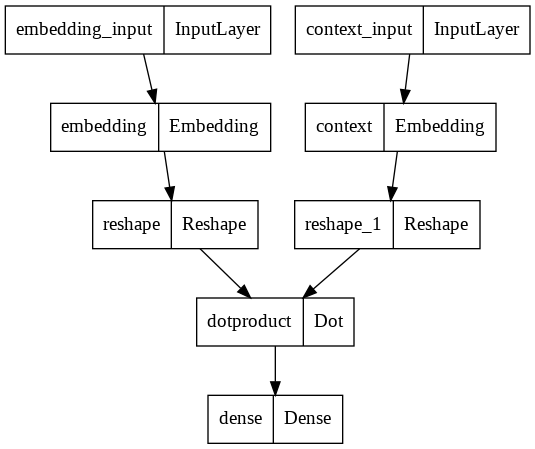

In [ ]:
keras.utils.plot_model(model)

In [ ]:
df = pd.concat([df_train, df_test, df_dev])

In [ ]:
df.shape

(28451, 4)

In [ ]:
vocabulary = []
for i in aug_df["augmented_text"].values:
  vocabulary += i.split()
vocabulary = set(vocabulary)
print(len(vocabulary))
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,vocab_size)
del vocabulary
stable = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
#print(stable)
couples, labels = tf.keras.preprocessing.sequence.skipgrams(data, vocab_size, window_size=2, sampling_table = stable)
word_target, word_context = zip(*couples)


model.fit([np.array(word_target,dtype='float32'), np.array(word_context,dtype='float32')],  np.array(labels,dtype='float32'), epochs = 5)

22500
Epoch 1/5
4105/4105 [==============================] - 22s 5ms/step - loss: 0.6932
Epoch 2/5
4105/4105 [==============================] - 18s 4ms/step - loss: 0.6308
Epoch 3/5
4105/4105 [==============================] - 18s 4ms/step - loss: 0.3853
Epoch 4/5
4105/4105 [==============================] - 20s 5ms/step - loss: 0.1146
Epoch 5/5
4105/4105 [==============================] - 18s 4ms/step - loss: 0.0116


In [ ]:
model.save_weights("/content/drive/MyDrive/word2vec_weights_augmented_df")

In [ ]:
def cosine_similarity(vectorA,vectorB):
    return np.dot(vectorA, vectorB)/(np.linalg.norm(vectorA)*np.linalg.norm(vectorB))

In [ ]:
from keras import backend as K

inp = word_model.input                                           # input placeholder
outputs = word_model.layers[-2].output          # all layer outputs
functors = K.function([inp], [outputs])    # evaluation functions

embeddings = {i: functors(dictionary[i]) for i in list(dictionary.keys())}

In [ ]:
len(functors(dictionary[list(dictionary.keys())[0]])[0]) 

300

In [ ]:
x = list(embeddings.values())

In [ ]:
import pickle

with open('/content/drive/MyDrive/custom_w2v_embeddings_augmented.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('/content/drive/MyDrive/custom_w2v_embeddings.pickle', 'rb') as handle:
    embeddings = pickle.load(handle)

In [ ]:
import warnings

In [ ]:
x_train = []
for i in aug_df["augmented_text"].values:
  x = []
  for j in i.split():
    if (j in embeddings.keys()):
      x.append(embeddings[j][0])
      #print(len(embeddings[j][0]))
  x = np.array(x)
  #print(x)
  with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        x_train.append(np.nanmean(x, axis=0))
    except RuntimeWarning:
        x_train.append(np.zeros(300))

In [ ]:
len(x_train)

42382

In [ ]:
with open('/content/drive/MyDrive/custom_w2v_augmented_train.pickle', 'wb') as handle:
    pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
x_test = []
for i in df_test["preprocessed_text"].values:
  x = []
  for j in i.split():
    if (j in embeddings.keys()):
      x.append(embeddings[j][0])
      #print(len(embeddings[j][0]))
  x = np.array(x)
  x_test.append(np.mean(x, axis = 0))

In [ ]:
x_dev = []
for i in df_dev["preprocessed_text"].values:
  x = []
  for j in i.split():
    if (j in embeddings.keys()):
      x.append(embeddings[j][0])
      #print(len(embeddings[j][0]))
  x = np.array(x)
  with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        x_dev.append(np.nanmean(x, axis=0))
    except RuntimeWarning:
        x_dev.append(np.zeros(300))  

In [ ]:
with open('/content/drive/MyDrive/custom_w2v_train.pickle', 'wb') as handle:
    pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/MyDrive/custom_w2v_test.pickle', 'wb') as handle:
    pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/MyDrive/custom_w2v_dev.pickle', 'wb') as handle:
    pickle.dump(x_dev, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
path = "/content/drive/MyDrive/word_embeddings/computed_embeddings"

In [ ]:
import os 
os.chdir("/content/Hope_speech/Models")

In [ ]:
from embeddings_loader import *

In [ ]:
train_labels, dev_labels, test_labels = load_labels(path)
label_replacement = {
    'Hope_speech': 0,
    'Non_hope_speech': 1,
    'not-English': 2,
}
# Replace labels with numbers
train_labels = [label_replacement[label] for label in train_labels]
dev_labels = [label_replacement[label] for label in dev_labels]
test_labels = [label_replacement[label] for label in test_labels]

In [ ]:
xgboost = XGBClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2), n_estimators = 100)

In [ ]:
xgboost.fit(x_train, train_labels)

XGBClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
              objective='multi:softprob')

In [ ]:
train_preds = xgboost.predict(x_train)
dev_preds = xgboost.predict(x_dev)
test_preds = xgboost.predict(x_test)

In [ ]:
import json, os
from venv import create
import pandas as pd
from joblib import dump, load
from embeddings_loader import *
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

In [ ]:
def computeAllScores(y_pred_train, y_pred_dev, y_pred_test):
    print("Accuracy Train: ", accuracy_score(train_labels, y_pred_train))
    print("Accuracy Dev: ", accuracy_score(dev_labels, y_pred_dev))
    print("Accuracy Test: ", accuracy_score(test_labels, y_pred_test))
    print("Weighted F1 Train: ", f1_score(train_labels, y_pred_train, average='weighted'))
    print("Weighted F1 Dev: ", f1_score(dev_labels, y_pred_dev, average='weighted'))
    print("Weighted F1 Test: ", f1_score(test_labels, y_pred_test, average='weighted'))
    print("Macro F1 Train: ", f1_score(train_labels, y_pred_train, average='macro'))
    print("Macro F1 Dev: ", f1_score(dev_labels, y_pred_dev, average='macro'))
    print("Macro F1 Test: ", f1_score(test_labels, y_pred_test, average='macro'))
    print("Micro F1 Train: ", f1_score(train_labels, y_pred_train, average='micro'))
    print("Micro F1 Dev: ", f1_score(dev_labels, y_pred_dev, average='micro'))
    print("Micro F1 Test: ", f1_score(test_labels, y_pred_test, average='micro'))
    print("Weighted Recall Train: ", recall_score(train_labels, y_pred_train, average='weighted'))
    print("Weighted Recall Dev: ", recall_score(dev_labels, y_pred_dev, average='weighted'))
    print("Weighted Recall Test: ", recall_score(test_labels, y_pred_test, average='weighted'))
    print("Macro Recall Train: ", recall_score(train_labels, y_pred_train, average='macro'))
    print("Macro Recall Dev: ", recall_score(dev_labels, y_pred_dev, average='macro'))
    print("Macro Recall Test: ", recall_score(test_labels, y_pred_test, average='macro'))
    print("Micro Recall Train: ", recall_score(train_labels, y_pred_train, average='micro'))
    print("Micro Recall Dev: ", recall_score(dev_labels, y_pred_dev, average='micro'))
    print("Micro Recall Test: ", recall_score(test_labels, y_pred_test, average='micro'))
    # Confusion Matrix
    print("Confusion Matrix Train: ")
    print(confusion_matrix(train_labels, y_pred_train))
    print("Confusion Matrix Dev: ")
    print(confusion_matrix(dev_labels, y_pred_dev))
    print("Confusion Matrix Test: ")
    print(confusion_matrix(test_labels, y_pred_test))

In [ ]:
computeAllScores(train_preds, dev_preds, test_preds)

Accuracy Train:  0.9160882172041122
Accuracy Dev:  0.9081955680619065
Accuracy Test:  0.9146170063246662
Weighted F1 Train:  0.8793754142946132
Weighted F1 Dev:  0.869838861608269
Weighted F1 Test:  0.8770797834068701
Macro F1 Train:  0.485698288242386
Macro F1 Dev:  0.351809366825834
Macro F1 Test:  0.34405448422762847
Micro F1 Train:  0.9160882172041122
Micro F1 Dev:  0.9081955680619064
Micro F1 Test:  0.9146170063246662
Weighted Recall Train:  0.9160882172041122
Weighted Recall Dev:  0.9081955680619065
Weighted Recall Test:  0.9146170063246662
Macro Recall Train:  0.43671837382016016
Macro Recall Dev:  0.351456181927812
Macro Recall Test:  0.3466666666666667
Micro Recall Train:  0.9160882172041122
Micro Recall Dev:  0.9081955680619065
Micro Recall Test:  0.9146170063246662
Confusion Matrix Train: 
[[   74  1888     0]
 [    6 20772     0]
 [    0    16     6]]
Confusion Matrix Dev: 
[[  15  257    0]
 [   2 2567    0]
 [   0    2    0]]
Confusion Matrix Test: 
[[  10  240    0]
 [  